<a href="https://colab.research.google.com/github/ParzivalStark/Velocity-Obstacles/blob/main/Velocity_Obstacle.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Librerias necesarias

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from shapely import Point, Polygon, intersection

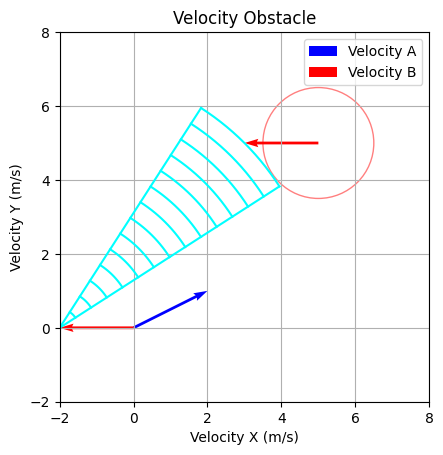

In [109]:
# Function to plot a circle
def plot_circle(ax, center, radius, color='r', fill=True, alpha=0.5):
    circle = Circle(center, radius, color=color, fill=fill, alpha=alpha)
    ax.add_patch(circle)

# Define the environment
A_pos = np.array([0, 0])  # Position of A
A_vel = np.array([2, 1])  # Velocity of A
A_radius = 0.5            # Radius of A

B_pos = np.array([5, 5])  # Position of B
B_vel = np.array([-2, 0])  # Velocity of B
B_radius = 1              # Radius of B

numPoints = 15

T_h = 10

relative_position = B_pos - A_pos
relative_velocity = B_vel - A_vel

# Calculate the collision cone angle
theta = np.arctan2(relative_position[1], relative_position[0])
distance_A_to_B = np.linalg.norm(relative_position)
beta = np.arcsin((A_radius + B_radius) / distance_A_to_B)

# Define the Collision Cone bounderies (CC_A,B)
rear_line = distance_A_to_B * np.array([np.cos(theta + beta),
                                        np.sin(theta + beta)])
front_line = distance_A_to_B * np.array([np.cos(theta - beta),
                                         np.sin(theta - beta)])
# Discretization
angles = np.linspace(theta - beta, theta + beta, numPoints)
conePoints = np.array([np.cos(angles), np.sin(angles)]).T

distances = np.linspace(0, distance_A_to_B, numPoints)
shiftedConePoints = []

for distance in distances:
  tmp = (conePoints * distance) + B_vel
  shiftedConePoints.append(tmp)

shiftedConePoints = np.array(shiftedConePoints)

#VO = set(map(tuple, shiftedConePoints.reshape(-1, 2)))

# Visualization
fig, ax = plt.subplots()
ax.quiver(*A_pos, *A_vel, color='b', scale_units='xy', scale=1, label="Velocity A")
ax.quiver(*B_pos, *B_vel, color='r', scale_units='xy', scale=1, label="Velocity B")
ax.quiver(*A_pos, *B_vel, color='r', scale_units='xy', scale=1)

# Plot the Velocity Obstacle (VO_B)
plot_circle(ax, B_pos, B_radius + A_radius, color='r', fill=False)
ax.plot([A_pos[0] + B_vel[0], rear_line[0] + B_vel[0]], [A_pos[1] + B_vel[1], rear_line[1] + B_vel[1]], 'cyan')
ax.plot([A_pos[0] + B_vel[0], front_line[0] + B_vel[0]], [A_pos[1] + B_vel[1], front_line[1] + B_vel[1]], 'cyan')

for points in shiftedConePoints:
  ax.plot(points[:, 0], points[:, 1], color='cyan')

# Plot configuration
ax.set_xlim(-2, 8)
ax.set_ylim(-2, 8)
ax.set_aspect('equal')
ax.legend()
ax.set_title('Velocity Obstacle')
plt.xlabel('Velocity X (m/s)')
plt.ylabel('Velocity Y (m/s)')
plt.grid(True)
plt.show()

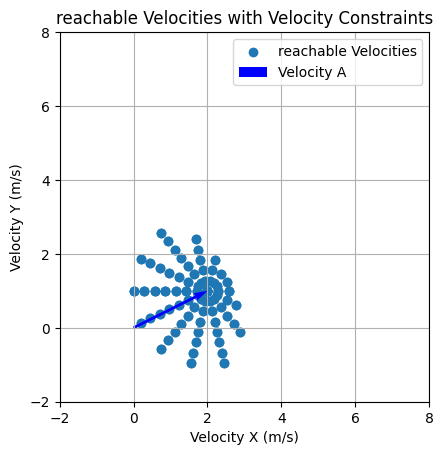

In [110]:
def reachable_velocities(v_A, v_max, a_max, dt=1.0, num_points=100):

    # Create a range of angles that span a full circle for acceleration directions
    angles = np.linspace(0, 2 * np.pi, num_points)

    # Compute the x and y components of the acceleration vectors
    circlePoints = np.array([np.cos(angles), np.sin(angles)]).T

    accelerations = np.linspace(-a_max, a_max, numPoints)
    acc_set = []

    for acc in accelerations:
      tmp = (circlePoints * acc)
      acc_set.append(tmp)

    acc_set = np.array(acc_set)

    # Compute the set of velocities by adding accelerations to the current velocity
    vel_set = []

    for i in acc_set:
      for j in i:
        # Compute the new velocity after applying this acceleration
        v_new = v_A + j * dt

        # Check if the new velocity would exceed the maximum velocity
        if np.linalg.norm(v_new) <= v_max:
            vel_set.append(v_new)

    vel_set = np.array(vel_set)

    return vel_set


v_max = 3.0                   # Maximum velocity (m/s)
a_max = 2.0                   # Maximum acceleration (m/s^2)
dt = 1.0                      # Time step (1 second)

# Get the set of feasible velocities
reachable_vel_set = reachable_velocities(A_vel, v_max, a_max, dt, numPoints)

# Plotting the result
fig, ax = plt.subplots()

#plt.figure(figsize=(6, 6))
plt.scatter(reachable_vel_set[:, 0], reachable_vel_set[:, 1], label="reachable Velocities")
ax.quiver(*A_pos, *A_vel, color='b', scale_units='xy', scale=1, label="Velocity A")
ax.set_xlim(-2, 8)
ax.set_ylim(-2, 8)
ax.set_aspect('equal')
plt.xlabel('Velocity X (m/s)')
plt.ylabel('Velocity Y (m/s)')
plt.grid(True)
#plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.title('reachable Velocities with Velocity Constraints')
plt.show()


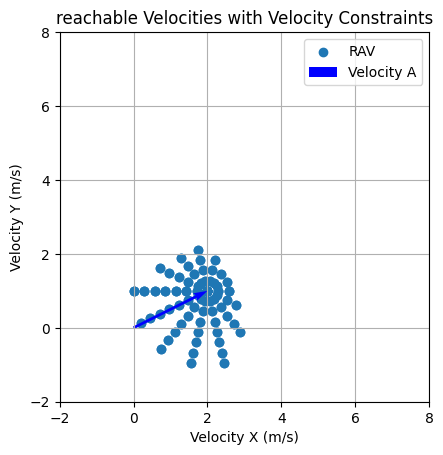

In [111]:
RAV = []

t_A =(A_pos[0] + B_vel[0], A_pos[1] + B_vel[1])
t_B =(rear_line[0] + B_vel[0], rear_line[1] + B_vel[1])
t_C =(front_line[0] + B_vel[0], front_line[1] + B_vel[1])
VO = Polygon((t_A, t_B, t_C))

for vel in reachable_vel_set:
  p_vel = Point(vel)
  if not intersection(p_vel, VO):
    RAV.append(vel)

RAV = np.array(RAV)

# Plotting the result
fig, ax = plt.subplots()
#plt.figure(figsize=(6, 6))
plt.scatter(RAV[:, 0], RAV[:, 1], label="RAV")
ax.quiver(*A_pos, *A_vel, color='b', scale_units='xy', scale=1, label="Velocity A")
ax.set_xlim(-2, 8)
ax.set_ylim(-2, 8)
ax.set_aspect('equal')
plt.xlabel('Velocity X (m/s)')
plt.ylabel('Velocity Y (m/s)')
plt.grid(True)
#plt.gca().set_aspect('equal', adjustable='box')
plt.legend()
plt.title('reachable Velocities with Velocity Constraints')
plt.show()

In [112]:
goal = np.array([2, 5]) ## position
rel_pos_goal = goal - A_pos
theta = np.arctan2(rel_pos_goal[1], rel_pos_goal[0])
print(theta)
best_vel = np.array([0, 0])
best_ang = 0
for vel in RAV:
  ang = np.arctan2(vel[1], vel[0])
  #print(ang)
  if (ang >= best_ang and ang <= theta) or (ang <= best_ang and ang >= theta):
    #print(vel, ang)
    if ang == best_ang:
      if np.linalg.norm(vel) > np.linalg.norm(best_vel):
        best_vel = vel
        best_ang = ang
    else:
        best_vel = vel
        best_ang = ang
print("Best", best_vel)

1.1902899496825317
Best [0.71290162 1.61983391]


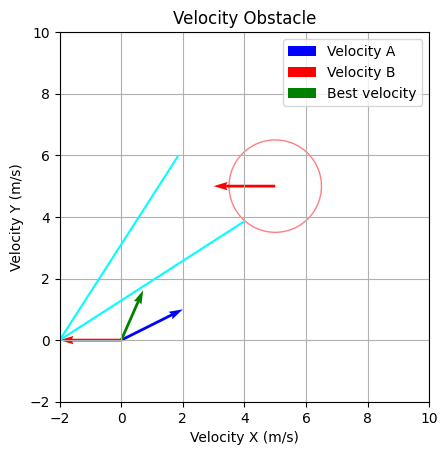

In [113]:
# Visualization
fig, ax = plt.subplots()
ax.quiver(*A_pos, *A_vel, color='b', scale_units='xy', scale=1, label="Velocity A")
ax.quiver(*B_pos, *B_vel, color='r', scale_units='xy', scale=1, label="Velocity B")
ax.quiver(*A_pos, *B_vel, color='r', scale_units='xy', scale=1)
ax.quiver(*A_pos, *best_vel, color='g', scale_units='xy', scale=1, label="Best velocity")

# Plot the Velocity Obstacle (VO_B)
plot_circle(ax, B_pos, B_radius + A_radius, color='r', fill=False)
ax.plot([A_pos[0] + B_vel[0], rear_line[0] + B_vel[0]], [A_pos[1] + B_vel[1], rear_line[1] + B_vel[1]], 'cyan')
ax.plot([A_pos[0] + B_vel[0], front_line[0] + B_vel[0]], [A_pos[1] + B_vel[1], front_line[1] + B_vel[1]], 'cyan')
#ax.plot(best_vel[0], best_vel[1], 'go')
# Plot configuration
ax.set_xlim(-2, 10)
ax.set_ylim(-2, 10)
ax.set_aspect('equal')
ax.legend()
ax.set_title('Velocity Obstacle')
plt.xlabel('Velocity X (m/s)')
plt.ylabel('Velocity Y (m/s)')
plt.grid(True)
plt.show()

In [38]:
t_A =(A_pos[0] + B_vel[0], A_pos[1] + B_vel[1])
t_B =(rear_line[0] + B_vel[0], rear_line[1] + B_vel[1])
t_C =(front_line[0] + B_vel[0], front_line[1] + B_vel[1])
t = Polygon((t_A, t_B, t_C))
p_in_t = intersection(p, t)
print(p_in_t)
print(bool(p_in_t))

POINT EMPTY
False


# Examples of points inside and outside VO

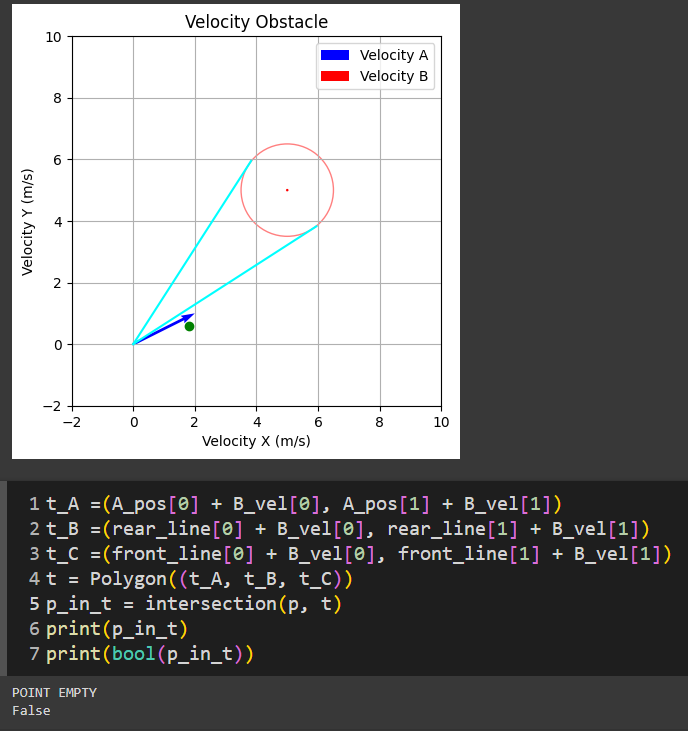

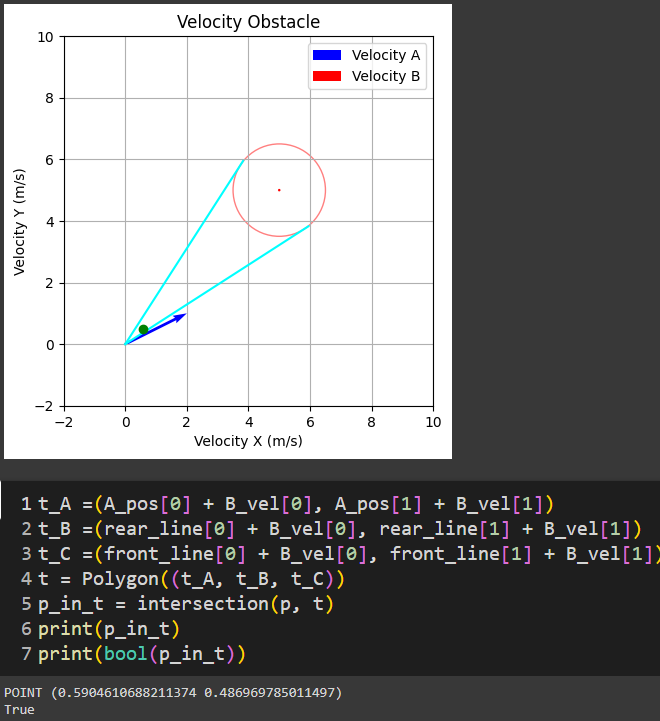

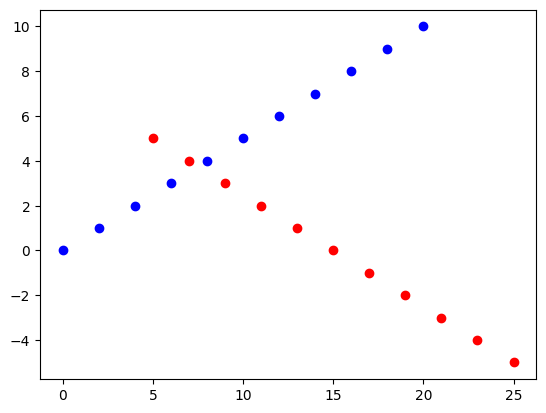

In [ ]:
t = 0
tf = 10
dt = 1

x_A = [A_pos[0]]
y_A = [A_pos[1]]

x_B = [B_pos[0]]
y_B = [B_pos[1]]

while t < tf:

  x_A.append(x_A[-1] + A_vel[0]*dt)
  y_A.append(y_A[-1] + A_vel[1]*dt)

  x_B.append(x_B[-1] + B_vel[0]*dt)
  y_B.append(y_B[-1] + B_vel[1]*dt)

  t += dt

plt.scatter(x_A, y_A, color='b')
plt.scatter(x_B, y_B, color='r')
plt.show()